Classificacao CNN
=================

1. Aquisição e pré-processamento dos dados
2. Treinamento
    1. Implementar arquitetura
    2. Definir otimizadores, métricas e regularizadores
3. Teste (avaliação de desempenho)

In [1]:
# Imports

import numpy as np
import pathlib
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
import torch

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Aquisição e pré-processamento dos dados

In [3]:
path = './../../Datasets/Exercicio_Tumores'
data = pathlib.Path(path)

In [4]:
disease = {
    "glioma_tumor": list(data.glob('glioma_tumor/*.jpg')),
    "meningioma_tumor": list(data.glob('meningioma_tumor/*.jpg')),
    "normal": list(data.glob('normal/*.jpg')),
    "pituitary_tumor" : list(data.glob('pituitary_tumor/*.jpg')),       
}

labels = {
    "glioma_tumor" : 0,
    "meningioma_tumor":1,
    "normal":2,
    "pituitary_tumor":3
}

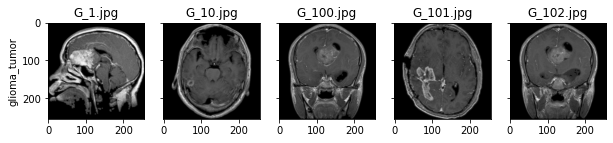

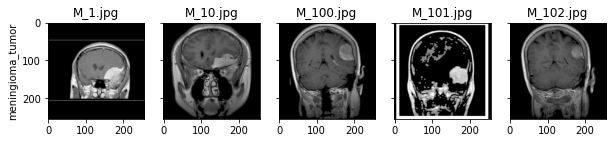

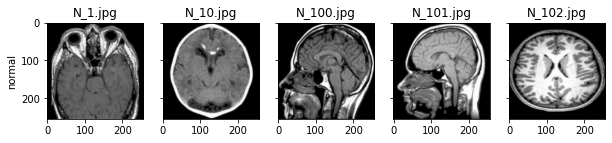

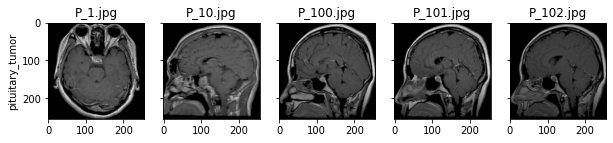

In [5]:
directory = os.listdir(path)

for each in disease.keys():
    plt.figure(figsize=(10, 10))
    currentFolder = path + '/' + each
    for i, file in enumerate(os.listdir(currentFolder)[0:5]):
        fullpath = path + '/' + each + "/" + file
        img=cv2.imread(fullpath)
        ax=plt.subplot(1,5,i+1)
        ax.set_title(file)
        if(i == 0):
            ax.set_ylabel(each)
        else:
            ax.set_yticklabels([])
        plt.imshow(img)

In [6]:
%%time
X = []
y = []
for name, diseases in tqdm(disease.items()):
    for disease in diseases:
        img = cv2.imread(str(disease))
        img = img.astype('float32') / 255.0
        X.append(img)
        y.append(labels[name])

100%|██████████| 4/4 [00:09<00:00,  2.35s/it]

CPU times: total: 4.92 s
Wall time: 9.41 s


## Treinamento

In [7]:
%%time
# Split train and test
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size = 0.2, random_state = 42)

# get 20% from train set and and extract a new validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

CPU times: total: 19.2 s
Wall time: 26.3 s


In [8]:
# Normalização
m = np.max(X_train)
X_train = X_train/m
X_test = X_test/m

In [9]:
# make binary categorization labels
hot = OneHotEncoder()
# '-1' get the length of array 
y_train = hot.fit_transform(y_train.reshape(-1, 1)).toarray()
y_val = hot.fit_transform(y_val.reshape(-1, 1)).toarray()
y_test = hot.transform(y_test.reshape(-1, 1)).toarray()

In [10]:
print("Shape of X_train: ", X_train.shape)
print("Shape of X_val: ", X_val.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of y_val: ", y_val.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (1980, 256, 256, 3)
Shape of X_val:  (496, 256, 256, 3)
Shape of X_test:  (620, 256, 256, 3)
Shape of y_train:  (1980, 4)
Shape of y_val:  (496, 4)
Shape of y_test:  (620, 4)


In [11]:
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)

In [12]:
from keras.layers import Dense, Dropout, MaxPool2D, Flatten, Conv2D
from keras.models import Sequential
from keras.callbacks import EarlyStopping


In [13]:
input_shape = [X_train.shape[1], X_train.shape[2], X_train.shape[3]]

rede_dropout = Sequential()
rede_dropout.add(Conv2D(filters=1, kernel_size=3, activation='relu', \
    input_shape=input_shape))
rede_dropout.add(Dropout(0.3))
rede_dropout.add(MaxPool2D(pool_size=(2,2)))
rede_dropout.add(Flatten())
rede_dropout.add(Dense(64, activation='relu'))
rede_dropout.add(Dropout(0.3))

rede_dropout.add(Dense(16, activation='relu'))
rede_dropout.add(Dropout(0.3))
rede_dropout.add(Dense(4, activation='softmax'))

rede_dropout.compile(loss = 'categorical_crossentropy', \
    optimizer = 'Adam', metrics=['accuracy'])


In [14]:
rede_dropout.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 1)       28        
                                                                 
 dropout (Dropout)           (None, 254, 254, 1)       0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 1)       0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 16129)             0         
                                                                 
 dense (Dense)               (None, 64)                1032320   
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

In [15]:
rede_dropout.compile(loss = 'categorical_crossentropy', \
    optimizer = 'Adam', metrics=['accuracy'])

In [16]:
%%time 

es = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 10, verbose = 1, mode = 'auto')

history = rede_dropout.fit(X_train, y_train, 
                             epochs = 100, 
                             verbose = 1,
                             validation_data = (X_val, y_val),
                             callbacks=[es])

Epoch 1/100
62/62 [==============================] - 21s 315ms/step - loss: 1.3230 - accuracy: 0.3429 - val_loss: 1.2008 - val_accuracy: 0.4940
Epoch 2/100
62/62 [==============================] - 18s 285ms/step - loss: 1.0265 - accuracy: 0.5657 - val_loss: 1.0070 - val_accuracy: 0.6230
Epoch 3/100
62/62 [==============================] - 17s 270ms/step - loss: 0.7839 - accuracy: 0.6864 - val_loss: 0.8729 - val_accuracy: 0.6593
Epoch 4/100
62/62 [==============================] - 16s 253ms/step - loss: 0.5712 - accuracy: 0.7833 - val_loss: 0.8174 - val_accuracy: 0.6855
Epoch 5/100
62/62 [==============================] - 16s 255ms/step - loss: 0.4370 - accuracy: 0.8328 - val_loss: 0.8114 - val_accuracy: 0.6976
Epoch 6/100
62/62 [==============================] - 16s 254ms/step - loss: 0.3271 - accuracy: 0.8909 - val_loss: 0.7782 - val_accuracy: 0.6935
Epoch 7/100
62/62 [==============================] - 16s 259ms/step - loss: 0.2507 - accuracy: 0.9157 - val_loss: 0.7886 - val_accuracy:

In [17]:
from sklearn.metrics import accuracy_score

X_test = np.expand_dims(X_test,axis=-1)
y_pred = rede_dropout.predict(X_test)

accuracy_score(y_test.argmax(1), y_pred.argmax(1))

20/20 [==============================] - 2s 104ms/step


0.7241935483870968

In [18]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test.argmax(1), y_pred.argmax(1))

array([[144,  30,   4,  21],
       [ 44, 105,  17,  20],
       [ 10,   5,  67,   7],
       [  6,   6,   1, 133]], dtype=int64)

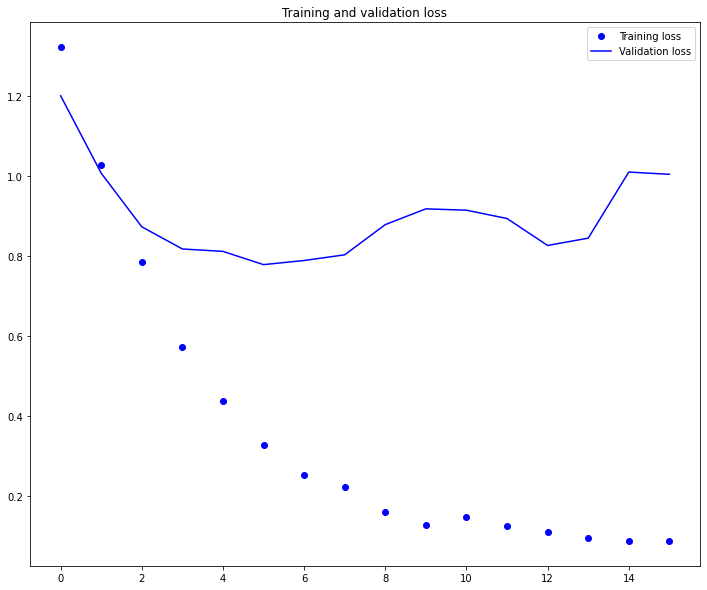

In [20]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.figure(figsize=(12,10))
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()